# MLP: MULTILAYER PERCEPTRON

**File:** MLP.ipynb

**Course:** Data Science Foundations: Data Mining in Python

# IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# LOAD AND PREPARE DATA

In [3]:
df = pd.read_csv('C:/Users/jamesal/OneDrive - UNC-Wilmington/Python/Codes/weather data_timeseries analysis.csv', parse_dates=['Timestamp'], index_col=['Timestamp'])
df

,Thermometer
Timestamp,
2019-02-01,55.36388
2019-03-01,55.26866
2019-04-01,65.52423
2019-05-01,76.33767
2019-06-01,78.53299
...,...
2024-10-01,66.60421
2024-11-01,60.75531
2024-12-01,49.81510


# PLOT DATA

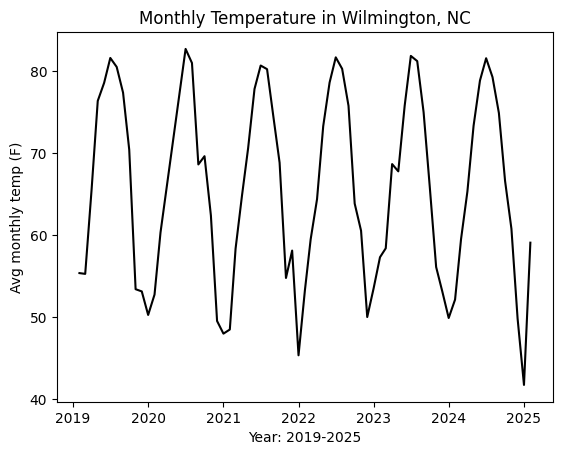

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 2019-2025')
plt.ylabel('Avg monthly temp (F)')
plt.title('Monthly Temperature in Wilmington, NC')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# RESHAPE DATA

- Reshape the data into an `n x (k + 1)` matrix where `n` is the number of samples and `k` is the number of features. 
- Use the last 12 lags of the time series as features (i.e. set `k` equal to 12) in order to capture a full seasonal cycle.

In [ ]:
k = 12

In [ ]:
Z = []

for i in range(k + 1, df.shape[0] + 1):
    Z.append(df.iloc[(i - k - 1): i, 0])

Z = np.array(Z)

- The first 12 columns of `Z` are the features (lags).
- The last column of `Z` is the target.

In [ ]:
Z.shape

(58, 13)

# SPLIT DATA

- Use the first 80% of the data for training and the remaining 20% of the data for testing.

In [ ]:
split = np.int64(0.8 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

# RESCALE DATA

- Normalize the data by subtracting the mean and dividing by the standard deviation.

In [ ]:
scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

- Extract the features (first 12 columns) and the target (last column).

In [ ]:
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

- Plot the normalized training data.

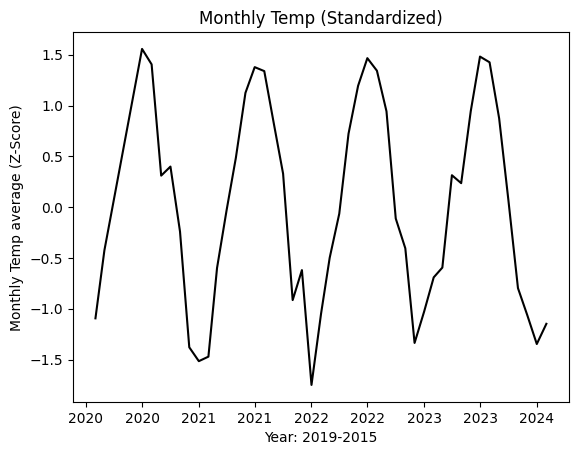

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 2019-2015')
plt.ylabel('Monthly Temp average (Z-Score)')
plt.title('Monthly Temp (Standardized)')
plt.plot(pd.Series(y_train, index=df.index[k: (k + len(y_train))]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

- Plot the normalized testing data.

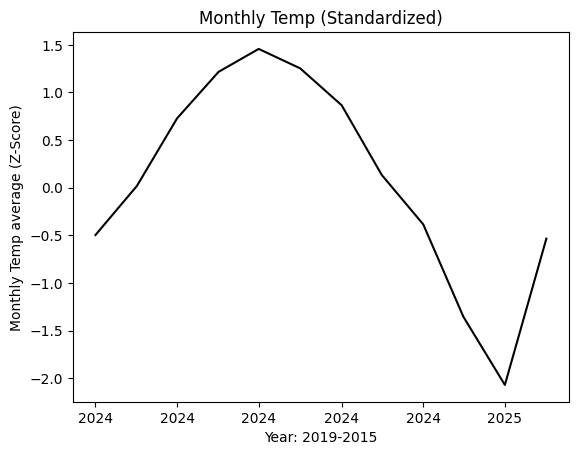

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 2019-2015')
plt.ylabel('Monthly Temp average (Z-Score)')
plt.title('Monthly Temp (Standardized)')
plt.plot(pd.Series(y_test, index=df.index[-len(y_test):]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# FIT MLP USING 20% VALIDATION SET

- Use the last 20% of the training data for validation.

In [ ]:
split_ = np.int64(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_, :], y_train[:split_]
X_valid_, y_valid_ =  X_train[split_:, :], y_train[split_:]

- Use the mean squared error (MSE) as validation loss.

In [ ]:
def validation_loss(hidden_neurons):
        
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
    
    mlp.fit(X_train_, y_train_)

    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

- Calculate the validation loss corresponding to different numbers of hidden nodes.

In [ ]:
params = [10, 25, 50, 75]
mse = [validation_loss(p) for p in params]

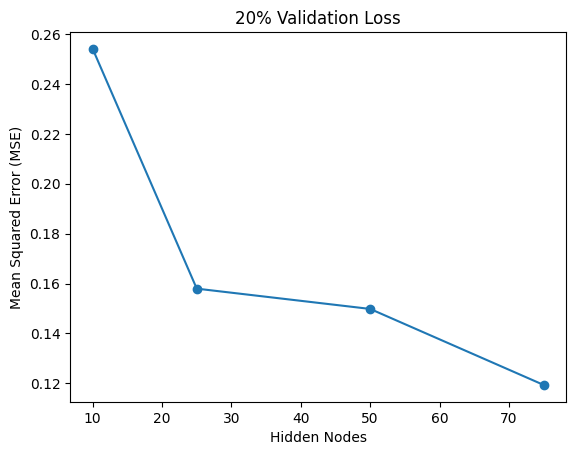

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('20% Validation Loss')
plt.plot(params, mse, '-o')

- Find the number of hidden nodes associated with the smallest validation loss.

In [ ]:
params[np.argmin(mse)]

75

- Fit an MLP model with 25 hidden nodes to the training data.

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(75,), max_iter=500, random_state=1, shuffle=False)

In [ ]:
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(75,), max_iter=500, random_state=1,
             shuffle=False)

- Use the fitted MLP model to forecast the test data.

In [ ]:
y_pred = mlp.predict(X_test)

- Transform the data back to the original scale.

In [ ]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

- Plot the data and the forecasts in the original scale.

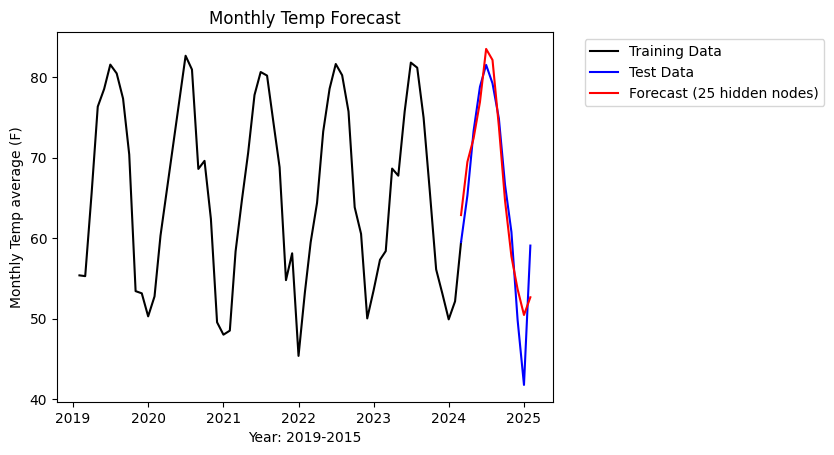

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 2019-2015')
plt.ylabel('Monthly Temp average (F)')
plt.title('Monthly Temp Forecast')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (25 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# FIT MLP USING FIVE-FOLD CROSS-VALIDATION

- Set up 5-fold cross validation.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

- Use the mean squared error (MSE) as cross-validation loss.

In [ ]:
def cross_validation_loss(hidden_neurons):
    
    mse = []
    
    for train_split_, valid_split_ in tscv.split(X_train):
        
        X_train_, y_train_ = X_train[train_split_], y_train[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], y_train[valid_split_] 
        
        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)
        
        mlp.fit(X_train_, y_train_)
        
        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))
        
    return np.mean(mse)

- Calculate the cross validation loss corresponding to different numbers of hidden nodes.

In [ ]:
params = [10, 25, 50, 75]
mse = [cross_validation_loss(p) for p in params]

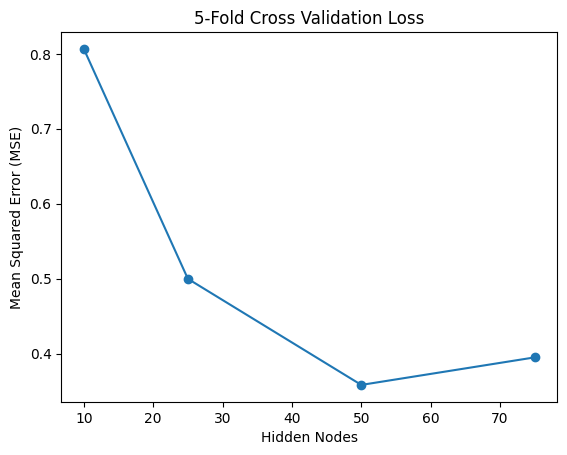

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross Validation Loss')
plt.plot(params, mse, '-o')

- Find the number of hidden nodes associated with the smallest cross validation loss.

In [ ]:
params[np.argmin(mse)]

50

- Fit an MLP model with 50 hidden nodes to the training data.

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1, shuffle=False)

In [ ]:
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1,
             shuffle=False)

- Use the fitted MLP model to forecast the test data.

In [ ]:
y_pred = mlp.predict(X_test)

- Transform the data back to the original scale.

In [ ]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

- Plot the data and the forecasts in the original scale.

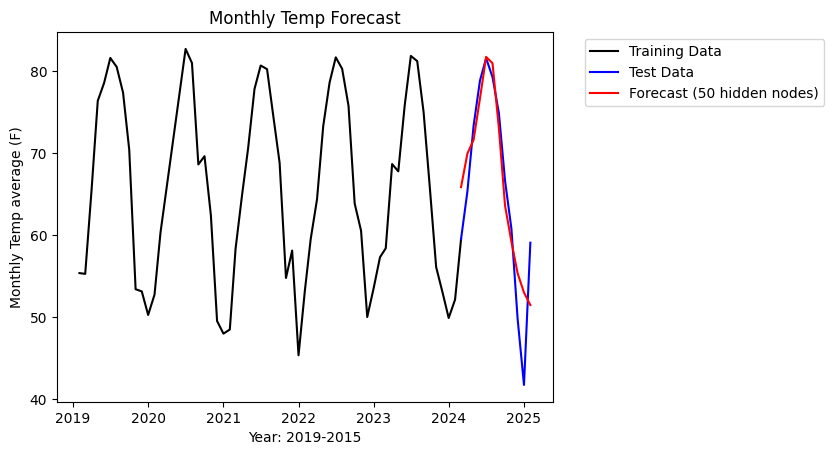

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 2019-2015')
plt.ylabel('Monthly Temp average (F)')
plt.title('Monthly Temp Forecast')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (50 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# CLEAN UP

- If desired, clear the results with Cell > All Output > Clear. 
- Save your work by selecting File > Save and Checkpoint.
- Shut down the Python kernel and close the file by selecting File > Close and Halt.